In [1]:
%pip install -q --upgrade keras keras-cv tensorflow tensorflow_datasets setuptools scikit-learn segmentation-models matplotlib opencv-python seaborn keras_tuner pandas
print("Successfully installed required packages.")


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install kaggle
# !kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels
!unzip chest-xray-masks-and-labels.zip
# !unzip tuberculosis-tb-chest-xray-dataset.zip
# !rm -rf data
!mv Lung\ Segmentation segmentation_data
!rm -rf ./segmentation_data/ClinicalReadings
!rm ./segmentation_data/NLM-ChinaCXRSet-ReadMe.docx
!rm ./segmentation_data/NLM-MontgomeryCXRSet-ReadMe.pdf
!mv ./segmentation_data/CXR_png ./segmentation_data/images
# !mv TB_Chest_Radiography_Database data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.8/162.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 19.3 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105787 sha256=02255ca368c6498cdfc07ceedca72ad5f3d15d86f2131ebdcdf1d25a76b809b7
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Dataset URL: https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels
License(s): CC0-1.0
100%|█████████████████████████████████████▉| 9.57G/9.58G [05:32<00:00, 35.7MB/s]
100%|██████████████████████████████████████| 9.58G/9.58G 

In [3]:
import os

DATA_DIR = "./segmentation_data"
image_dir = os.path.join(DATA_DIR, "images")
mask_dir = os.path.join(DATA_DIR, "masks")

masks = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]
for mask in masks:
    if mask.endswith("_mask.png"):
        os.rename(os.path.join(mask_dir, mask), os.path.join(mask_dir, mask.replace("_mask", "")))

images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
for img in images:
    if os.path.isfile(os.path.join(mask_dir, img)):
        continue
    os.remove(os.path.join(image_dir, img))

# Split the dataset into training and validation sets
images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
masks = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]

In [4]:
from sklearn.model_selection import train_test_split
import shutil

images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
masks = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.1)

if os.path.exists(os.path.join(DATA_DIR, "train")):
    print("Removing existing train dataset...")
    shutil.rmtree(os.path.join(DATA_DIR, "train"))

if os.path.exists(os.path.join(DATA_DIR, "val")):
    print("Removing existing validation dataset...")
    shutil.rmtree(os.path.join(DATA_DIR, "val"))

train_image_dir = os.path.join(DATA_DIR, "train", "images")
val_image_dir = os.path.join(DATA_DIR, "val", "images")
train_mask_dir = os.path.join(DATA_DIR, "train", "masks")
val_mask_dir = os.path.join(DATA_DIR, "val", "masks")

os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)

def copy_files(file_list, src_dir, dst_dir):
    for file in file_list:
        shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

print("Copying train images...")
copy_files(train_images, image_dir, train_image_dir)
print("Copying validation images...")
copy_files(val_images, image_dir, val_image_dir)
print("Copying train masks...")
copy_files(train_masks, mask_dir, train_mask_dir)
print("Copying validation masks...")
copy_files(val_masks, mask_dir, val_mask_dir)

Copying train images...
Copying validation images...
Copying train masks...
Copying validation masks...


In [5]:
import keras
import tensorflow as tf

train_masks_dir = os.path.join(DATA_DIR, "train", "masks")
train_images_dir = os.path.join(DATA_DIR, "train", "images")
val_masks_dir = os.path.join(DATA_DIR, "val", "masks")
val_images_dir = os.path.join(DATA_DIR, "val", "images")

train_masks = keras.utils.image_dataset_from_directory(
    train_masks_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=8,
    image_size=(256, 256)
)

train_images = keras.utils.image_dataset_from_directory(
    train_images_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=8,
    image_size=(256, 256)
)

val_masks = keras.utils.image_dataset_from_directory(
    val_masks_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=8,
    image_size=(256, 256)
)

val_images = keras.utils.image_dataset_from_directory(
    val_images_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=8,
    image_size=(256, 256)
)

train_dataset = tf.data.Dataset.zip((train_images, train_masks))
val_dataset = tf.data.Dataset.zip((val_images, val_masks))

train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y / 255.0))
val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y / 255.0))

Found 633 files.


Found 633 files.
Found 71 files.
Found 71 files.


In [6]:
import os
import keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

BACKBONE = 'resnet34'
early_stopper = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

base_model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet',
)

inp = keras.layers.Input(shape=(256, 256, 1))
l1 = keras.layers.Conv2D(3, (1, 1))(inp)
out = base_model(l1)

model = keras.models.Model(inp, out, name=base_model.name)

model.compile(
    keras.optimizers.Adam(learning_rate=0.001),
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.iou_score, sm.metrics.FScore],
)

history = model.fit(train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[early_stopper]
)

Segmentation Models: using `tf.keras` framework.
85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5


I0000 00:00:1723801281.367135    2577 service.cc:146] XLA service 0x7fb9e0002970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723801281.367226    2577 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-08-16 09:41:26.780046: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-16 09:41:29.321540: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


 3/80 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - f1-score: 0.4072 - iou_score: 0.2568 - loss: 0.5928  

I0000 00:00:1723801307.106581    2577 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 72s 343ms/step - f1-score: 0.6025 - iou_score: 0.4389 - loss: 0.3976 - val_f1-score: 0.5738 - val_iou_score: 0.4027 - val_loss: 0.4257
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - f1-score: 0.7714 - iou_score: 0.6284 - loss: 0.2287 - val_f1-score: 0.6153 - val_iou_score: 0.4445 - val_loss: 0.3849
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - f1-score: 0.7839 - iou_score: 0.6455 - loss: 0.2161 - val_f1-score: 0.7597 - val_iou_score: 0.6133 - val_loss: 0.2407
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - f1-score: 0.7873 - iou_score: 0.6500 - loss: 0.2127 - val_f1-score: 0.7830 - val_iou_score: 0.6440 - val_loss: 0.2168
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - f1-score: 0.7905 - iou_score: 0.6547 - loss: 0.2095 - val_f1-score: 0.7868 - val_iou_score: 0.6498 - val_loss: 0.2135


Found 96 files.
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


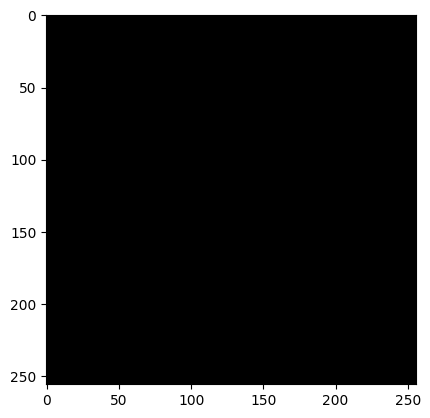

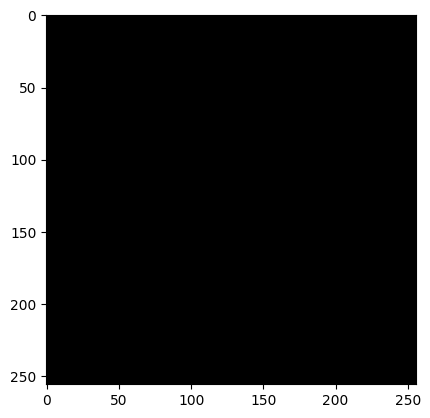

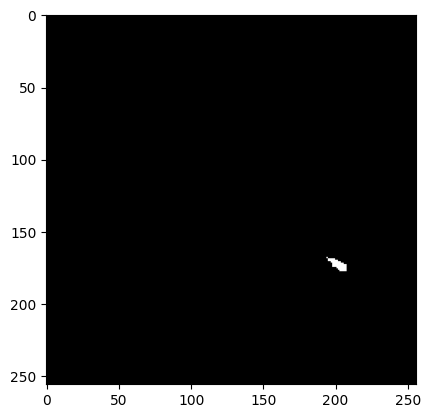

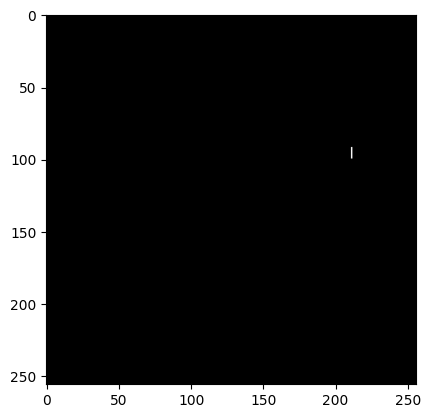

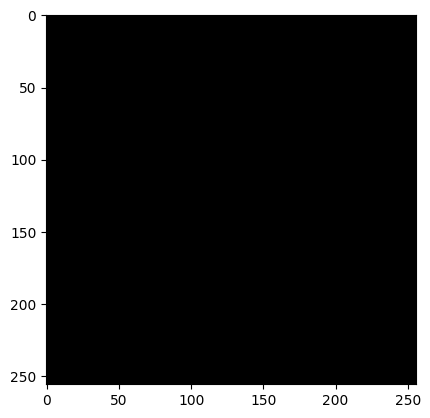

In [7]:
import numpy as np
import matplotlib.pyplot as plt

test_images_dir = os.path.join(DATA_DIR, "test")
test_images = keras.utils.image_dataset_from_directory(
    test_images_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

results = model.predict(test_images)
for i in range(5):
    pred = results[i]
    pred = np.squeeze(pred)
    pred = (pred > 0.5).astype(np.uint8)
    plt.imshow(pred, cmap='gray')
    plt.show()


In [6]:
import os
import keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0
)

BACKBONE = 'resnet34'
base_model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet',
)

inp = keras.layers.Input(shape=(256, 256, 1))
l1 = keras.layers.Conv2D(3, (1, 1))(inp)
out = base_model(l1)

model = keras.models.Model(inp, out, name=base_model.name)

model.compile(
    keras.optimizers.Adam(learning_rate=0.001),
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.iou_score, sm.metrics.FScore],
)

history = model.fit(train_dataset,
    epochs=15,
    validation_data=val_dataset,
    callbacks=[reduce_lr_cb]
)

Epoch 1/15


I0000 00:00:1723801548.660389    9108 service.cc:146] XLA service 0x7fdb40004510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723801548.660461    9108 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-08-16 09:45:53.439188: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-16 09:45:55.820706: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


 3/80 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - f1-score: 0.3389 - iou_score: 0.2044 - loss: 0.6611  

I0000 00:00:1723801572.955231    9108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 322ms/step - f1-score: 0.5915 - iou_score: 0.4321 - loss: 0.4084 - val_f1-score: 0.6874 - val_iou_score: 0.5241 - val_loss: 0.3132 - learning_rate: 0.0010
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - f1-score: 0.7727 - iou_score: 0.6306 - loss: 0.2273 - val_f1-score: 0.7400 - val_iou_score: 0.5878 - val_loss: 0.2606 - learning_rate: 0.0010
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - f1-score: 0.7852 - iou_score: 0.6472 - loss: 0.2148 - val_f1-score: 0.7860 - val_iou_score: 0.6477 - val_loss: 0.2143 - learning_rate: 0.0010
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - f1-score: 0.7942 - iou_score: 0.6594 - loss: 0.2058 - val_f1-score: 0.7713 - val_iou_score: 0.6285 - val_loss: 0.2288 - learning_rate: 0.0010
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - f1-score: 0.7890 - iou_score: 0.6528 - loss: 0.2109 - val_f1-score: 0.7918 - val_iou_score: 0.6557 - val_loss: 0.2084 - learning_rate: 0.0010
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━

In [21]:
def unet(input_size=(256,256,1)):
    inputs = keras.layers.Input(input_size)
    s = keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = keras.layers.Dropout(0.1)(c1)
    c1 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = keras.layers.Dropout(0.1)(c2)
    c2 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = keras.layers.Dropout(0.2)(c3)
    c3 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = keras.layers.MaxPooling2D((2, 2))(c3)
    
    c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = keras.layers.Dropout(0.2)(c4)
    c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = keras.layers.Dropout(0.3)(c5)
    c5 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = keras.layers.Dropout(0.2)(c6)
    c6 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = keras.layers.Dropout(0.2)(c7)
    c7 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = keras.layers.Dropout(0.1)(c8)
    c8 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = keras.layers.concatenate([u9, c1], axis=3)
    c9 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = keras.layers.Dropout(0.1)(c9)
    c9 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = keras.Model(inputs=[inputs], outputs=[outputs])

    return model

In [35]:
import keras
import tensorflow as tf

ckpt_dir = './models/base_line/ckpt'
checkpoint_filepath = '%s/checkpoint.model.keras' % (ckpt_dir)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

model = unet()
model.compile(
    keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])],
)

reduceLROnPlat = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, 
    patience=3, 
    verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6
)
callbacks_list = [reduceLROnPlat, model_checkpoint_callback]

loss_history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=callbacks_list
)

Epoch 1/20


80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 122ms/step - io_u_8: 0.7106 - loss: 0.5642 - val_io_u_8: 0.7472 - val_loss: 0.3783 - learning_rate: 0.0010
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - io_u_8: 0.7116 - loss: 0.3647 - val_io_u_8: 0.7472 - val_loss: 0.2923 - learning_rate: 0.0010
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - io_u_8: 0.7114 - loss: 0.3118 - val_io_u_8: 0.7472 - val_loss: 0.3268 - learning_rate: 0.0010
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - io_u_8: 0.7108 - loss: 0.2941 - val_io_u_8: 0.7472 - val_loss: 0.2758 - learning_rate: 0.0010
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - io_u_8: 0.7103 - loss: 0.2772 - val_io_u_8: 0.7472 - val_loss: 0.2757 - learning_rate: 0.0010
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - io_u_8: 0.7118 - loss: 0.2739 - val_io_u_8: 0.7472 - val_loss: 0.3121 - learning_rate: 0.0010
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - io_u_8: 0.7114 - loss: 0.2839 - val_io_u_8: 0.7472 - val_loss: 0.2731 - le

Found 96 files.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


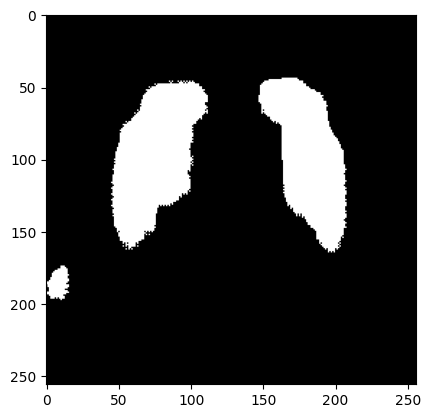

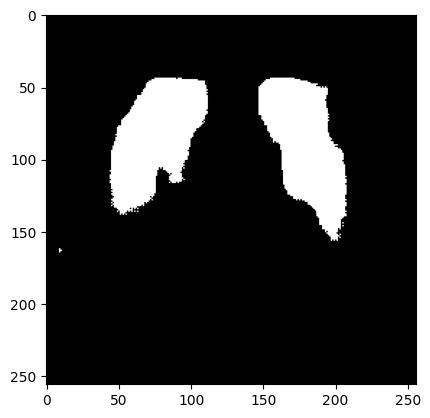

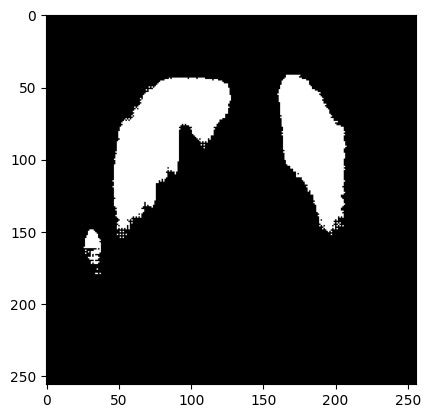

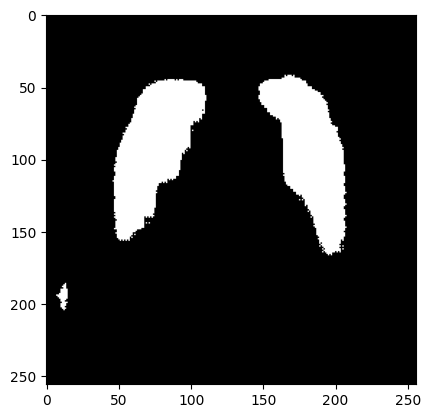

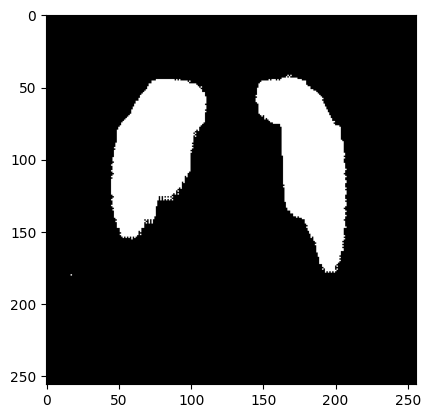

In [36]:
import numpy as np
import matplotlib.pyplot as plt

test_images_dir = os.path.join(DATA_DIR, "test")
test_images = keras.utils.image_dataset_from_directory(
    test_images_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

results = model.predict(test_images)
for i in range(5):
    pred = results[i]
    pred = np.squeeze(pred)
    pred = (pred > 0.5).astype(np.uint8)
    plt.imshow(pred, cmap='gray')
    plt.show()


In [6]:
import glob
import cv2
import os
import numpy as np

train_images = []
for directory_path in glob.glob("segmentation_data/train/images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
     
train_images = np.array(train_images)

train_masks = []
for directory_path in glob.glob("segmentation_data/train/masks"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (256, 256))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_masks.append(img)

train_masks = np.array(train_masks)

validation_images = []
for directory_path in glob.glob("segmentation_data/val/images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        validation_images.append(img)

validation_images = np.array(validation_images)

validation_masks = []
for directory_path in glob.glob("segmentation_data/val/masks"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (256, 256))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        validation_masks.append(img)

validation_masks = np.array(validation_masks)

In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
import keras

BACKBONE = 'resnet34'
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
preprocess_input = sm.get_preprocessing(BACKBONE)

train_images = preprocess_input(train_images)
validation_images = preprocess_input(validation_images)
train_masks = train_masks.astype(np.float32)
train_masks = train_masks / 255
validation_masks = validation_masks.astype(np.float32)
validation_masks = validation_masks / 255

model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.002,
    patience=5,
    start_from_epoch=15,
)

callbacks_list = [early_stopping]
model.fit(
   x=train_images,
   y=train_masks,
   batch_size=16,
   epochs=1,
   validation_data=(validation_images, validation_masks),
   callbacks=callbacks_list
)

Epoch 1/200


I0000 00:00:1723826464.833792   43836 service.cc:146] XLA service 0x7ef574001ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723826464.833861   43836 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-08-16 16:41:05.278964: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-16 16:41:07.209107: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


 3/40 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - iou_score: 0.2240 - loss: 1.5618  

I0000 00:00:1723826483.023697   43836 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - iou_score: 0.3775 - loss: 1.1076

E0000 00:00:1723826489.995479   43841 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


40/40 ━━━━━━━━━━━━━━━━━━━━ 58s 627ms/step - iou_score: 0.3835 - loss: 1.0930 - val_iou_score: 0.3329 - val_loss: 5.8452
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - iou_score: 0.5683 - loss: 0.7040 - val_iou_score: 0.4903 - val_loss: 2.4481
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - iou_score: 0.5955 - loss: 0.6686 - val_iou_score: 0.5671 - val_loss: 1.4154
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - iou_score: 0.6032 - loss: 0.6580 - val_iou_score: 0.5888 - val_loss: 0.9930
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - iou_score: 0.6095 - loss: 0.6455 - val_iou_score: 0.5778 - val_loss: 1.0945
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - iou_score: 0.6108 - loss: 0.6450 - val_iou_score: 0.5818 - val_loss: 1.1046
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - iou_score: 0.6255 - loss: 0.6193 - val_iou_score: 0.6017 - val_loss: 0.8938
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - iou_score: 0.6300 - loss: 0.6075 - val_iou_sco

Found 96 files.


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


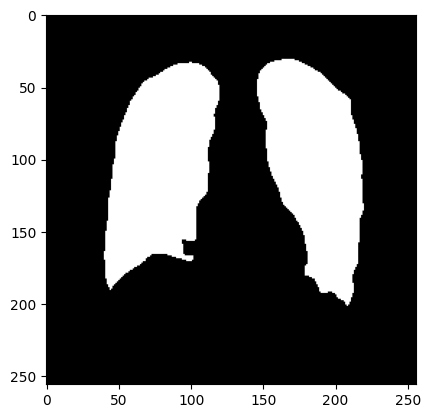

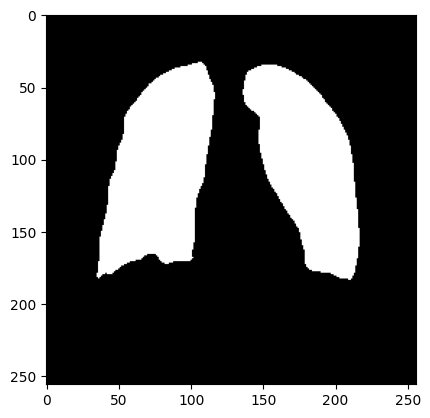

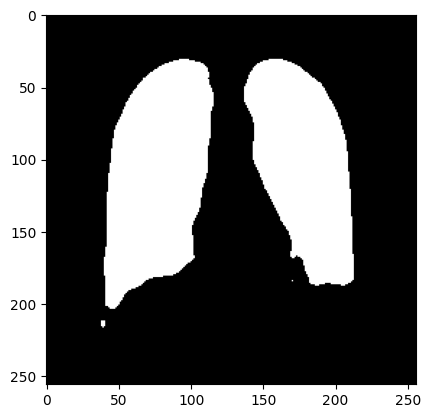

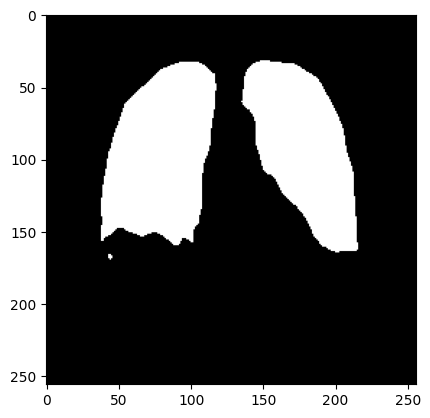

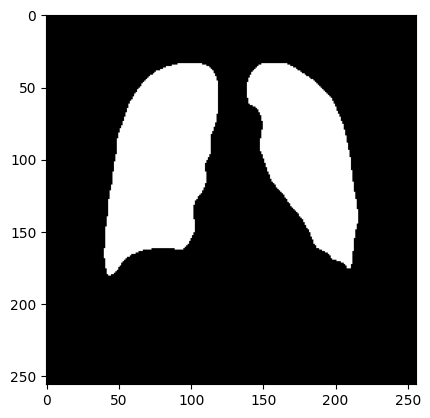

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import keras

DATA_DIR = "./segmentation_data"

test_images_dir = os.path.join(DATA_DIR, "test")
test_images = keras.utils.image_dataset_from_directory(
    test_images_dir,
    label_mode=None,
    batch_size=16,
    image_size=(256, 256)
)

results = model.predict(test_images)
for i in range(5):
    pred = results[i]
    pred = np.squeeze(pred)
    pred = (pred > 0.5).astype(np.uint8)
    plt.imshow(pred, cmap='gray')
    plt.show()


In [7]:
import shutil
import os

test_filenames = os.listdir(test_images_dir)

if os.path.exists(os.path.join(DATA_DIR, "out")):
    print("Removing existing output directory...")
    shutil.rmtree(os.path.join(DATA_DIR, "out"))

os.makedirs(os.path.join(DATA_DIR, "out"), exist_ok=True)
out_dir = os.path.join(DATA_DIR, "out")
for pred, fn in zip(results, test_filenames):
    pred = np.squeeze(pred)
    pred = (pred > 0.5).astype(np.uint8)
    plt.imsave(os.path.join(out_dir, fn), pred, cmap="gray")

Removing existing output directory...


In [9]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

overlayed_out = os.path.join(DATA_DIR, "overlayed_out")

os.makedirs(overlayed_out, exist_ok=True)

def overlay_mask_on_image(image, mask):
    mask = mask > 0.5
    overlay_image = np.zeros_like(image)
    overlay_image[mask] = image[mask]

    return overlay_image

for img_name in os.listdir(test_images_dir):
    img_path = os.path.join(test_images_dir, img_name)
    mask_path = os.path.join(out_dir, img_name)

    original_image = cv2.imread(img_path)
    original_image = cv2.resize(original_image, (256, 256))

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255.0
    
    overlay_image = overlay_mask_on_image(original_image, mask)

    cv2.imwrite(os.path.join(overlayed_out, img_name), overlay_image)


In [11]:
import keras

loss=sm.losses.bce_jaccard_loss,
metrics=[sm.metrics.iou_score]

model = keras.models.load_model(checkpoint_filepath, )

import shutil
import os

test_filenames = os.listdir(test_images_dir)

if os.path.exists(os.path.join(DATA_DIR, "out")):
    print("Removing existing output directory...")
    shutil.rmtree(os.path.join(DATA_DIR, "out"))

os.makedirs(os.path.join(DATA_DIR, "out"), exist_ok=True)
out_dir = os.path.join(DATA_DIR, "out")
for pred, fn in zip(results, test_filenames):
    pred = np.squeeze(pred)
    pred = (pred > 0.5).astype(np.uint8)
    plt.imsave(os.path.join(out_dir, fn), pred, cmap="gray")

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

overlayed_out = os.path.join(DATA_DIR, "overlayed_out")

os.makedirs(overlayed_out, exist_ok=True)

def overlay_mask_on_image(image, mask):
    mask = mask > 0.5
    overlay_image = np.zeros_like(image)
    overlay_image[mask] = image[mask]

    return overlay_image

for img_name in os.listdir(test_images_dir):
    img_path = os.path.join(test_images_dir, img_name)
    mask_path = os.path.join(out_dir, img_name)

    original_image = cv2.imread(img_path)
    original_image = cv2.resize(original_image, (256, 256))

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255.0
    
    overlay_image = overlay_mask_on_image(original_image, mask)

    cv2.imwrite(os.path.join(overlayed_out, img_name), overlay_image)


TypeError: Unable to reconstruct an instance of 'SumOfLosses' because the class is missing a `from_config()` method. Full object config: {'module': 'segmentation_models.base.objects', 'class_name': 'SumOfLosses', 'config': 'binary_crossentropy_plus_jaccard_loss', 'registered_name': 'SumOfLosses'}

# Grid Search

In [17]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

train_images = preprocess_input(train_images)
validation_images = preprocess_input(validation_images)
train_masks = train_masks.astype(np.float32)
train_masks = train_masks / 255
validation_masks = validation_masks.astype(np.float32)
validation_masks = validation_masks / 255

def build_model(hp):
    model = sm.Unet(BACKBONE, encoder_weights='imagenet')

    optimizer = hp.Choice('optimizer', ['Adam', 'SGD'])
    # loss = hp.Choice('loss', [sm.losses.jaccard_loss, sm.losses.bce_jaccard_loss, sm.losses.dice_loss, sm.losses.bce_dice_loss])
    loss = sm.losses.bce_dice_loss
    model.compile(
        optimizer,
        loss=loss,
        metrics=[sm.metrics.iou_score],
    )

    return model


In [18]:
import keras_tuner
import keras

tuner = keras_tuner.GridSearch(
    build_model,
    objective='val_loss',
    max_trials=100
)

tuner.search(
    train_images,
    train_masks,
    epochs=100,
    validation_data=(validation_images, validation_masks),
)


AttributeError: module 'segmentation_models.losses' has no attribute 'bce_dice_liss'

Found 96 files.
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`


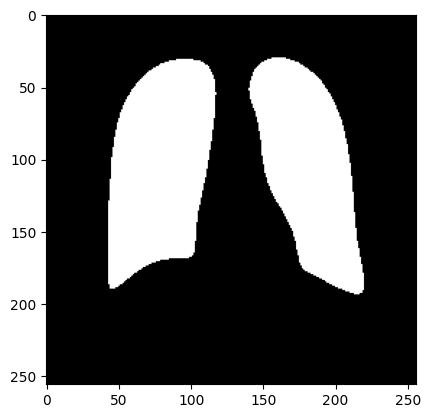

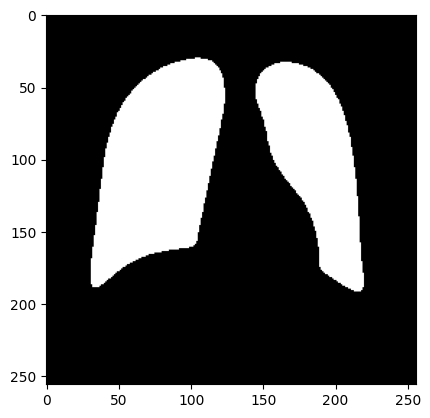

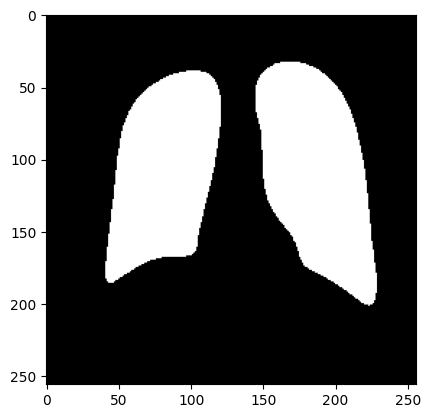

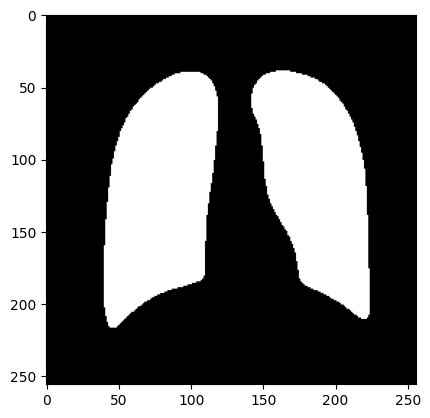

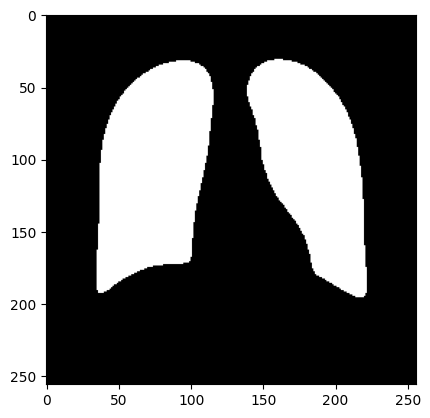

Removing existing output directory...


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import keras

best_models = tuner.get_best_models()
DATA_DIR = "./segmentation_data"

test_images_dir = os.path.join(DATA_DIR, "test")
test_images = keras.utils.image_dataset_from_directory(
    test_images_dir,
    label_mode=None,
    batch_size=16,
    image_size=(256, 256)
)

for model in best_models:
    results = model.predict(test_images)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`')
    for i in range(5):
        pred = results[i]
        pred = np.squeeze(pred)
        pred = (pred > 0.5).astype(np.uint8)
        plt.imshow(pred, cmap='gray')
        plt.show()

import shutil
import os

test_filenames = os.listdir(test_images_dir)

if os.path.exists(os.path.join(DATA_DIR, "out")):
    print("Removing existing output directory...")
    shutil.rmtree(os.path.join(DATA_DIR, "out"))

os.makedirs(os.path.join(DATA_DIR, "out"), exist_ok=True)
out_dir = os.path.join(DATA_DIR, "out")
for pred, fn in zip(results, test_filenames):
    pred = np.squeeze(pred)
    pred = (pred > 0.5).astype(np.uint8)
    plt.imsave(os.path.join(out_dir, fn), pred, cmap="gray")

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

overlayed_out = os.path.join(DATA_DIR, "overlayed_out")

os.makedirs(overlayed_out, exist_ok=True)

def overlay_mask_on_image(image, mask):
    mask = mask > 0.5
    overlay_image = np.zeros_like(image)
    overlay_image[mask] = image[mask]

    return overlay_image

for img_name in os.listdir(test_images_dir):
    img_path = os.path.join(test_images_dir, img_name)
    mask_path = os.path.join(out_dir, img_name)

    original_image = cv2.imread(img_path)
    original_image = cv2.resize(original_image, (256, 256))

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255.0
    
    overlay_image = overlay_mask_on_image(original_image, mask)

    cv2.imwrite(os.path.join(overlayed_out, img_name), overlay_image)
